<a href="https://colab.research.google.com/github/Omega-84/ML-Capstone-Project-Regression-TedTalksViewPrediction/blob/individual/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive._mount('/content/drive') 

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from warnings import filterwarnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline 
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.metrics import r2_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
!pip install category_encoders
from category_encoders import CatBoostEncoder,TargetEncoder
from yellowbrick.cluster import KElbowVisualizer
filterwarnings("ignore")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Capstone 3 Regression/ted_new.csv")

In [ ]:
def ted_name(text):
  if 'ted' in text.lower():
    return 1
  else:
    return 0

In [ ]:
df['ted_in_name'] = df['event'].apply(ted_name)

In [ ]:
df['ted_in_name'].sum()/len(df) * 100

96.4294631710362

In [ ]:
df.head()

,Unnamed: 0,talk_id,title,speaker_1,all_speakers,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript,occupation,no_of_lang,cleaned_description,release_day,release_month,release_year,cleaned_transcription,talk_category
0,0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,16.283333,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",climate advocate,43,humor humanity exude An Inconvenient Truth Al ...,Tuesday,June,2006,thank Chris truly great honor opportunity come...,Culture and society
1,1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,19.833333,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",global health expert; data visionary,49,datum present like drama urgency sportscaster ...,Tuesday,June,2006,year ago task teach global development swedish...,International topics
2,2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,21.433333,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",technology columnist,26,New York Times columnist David Pogue aim techn...,Tuesday,June,2006,music sound silence Simon Garfunkel hello voic...,Culture and society
3,3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,18.600000,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,activist for environmental justice,35,emotionally charge talk MacArthur win activist...,Tuesday,June,2006,today happy hear sustainable development save ...,Climate change
4,4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,19.400000,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,author,62,Sir Ken Robinson entertaining profoundly case ...,Tuesday,June,2006,good morning audience good great blow away thi...,Finance and economics


In [ ]:
topic_df = pd.DataFrame(df.groupby(['talk_category'])['views'].mean()).reset_index().sort_values('views',ascending=False)
topic_df

,talk_category,views
2,Culture and society,3.105415e+06
3,Environment and ecology,2.846010e+06
4,Finance and economics,2.400798e+06
0,Architecture and design,2.035496e+06
7,Music and Entertainment,1.910822e+06
9,Social issues,1.845461e+06
6,International topics,1.776163e+06
5,Health and medicine,1.557084e+06
8,"Science, technology and innovation",1.484271e+06
1,Climate change,1.425952e+06


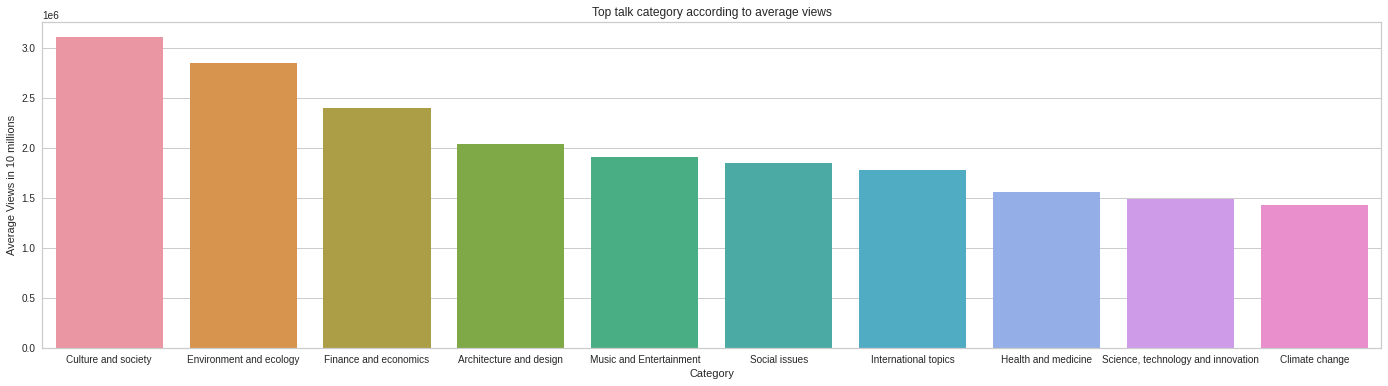

In [ ]:
plt.figure(figsize=(24,6))
plt.title('Top talk category according to average views')
sns.barplot(x='talk_category',y='views',data=topic_df)
plt.xlabel("Category")
plt.ylabel('Average Views in 10 millions');

In [ ]:
event_df = pd.DataFrame(df.groupby(['event'])['views'].sum()).reset_index().sort_values('views',ascending=False).head(10)
event_df 

,event,views
47,TED-Ed,1145357780
67,TED2015,247702961
66,TED2014,240295871
114,TEDGlobal 2013,235410234
69,TED2017,227847725
68,TED2016,227358612
65,TED2013,225967516
64,TED2012,197746106
70,TED2018,196346377
61,TED2009,191190144


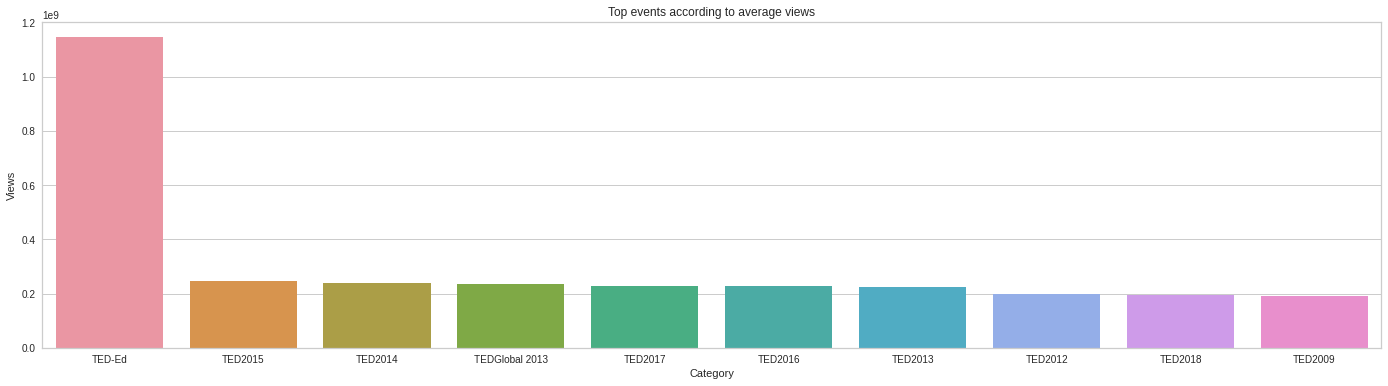

In [ ]:
plt.figure(figsize=(24,6))
plt.title('Top events according to average views')
sns.barplot(x='event',y='views',data=event_df)
plt.xlabel("Category")
plt.ylabel('Views');

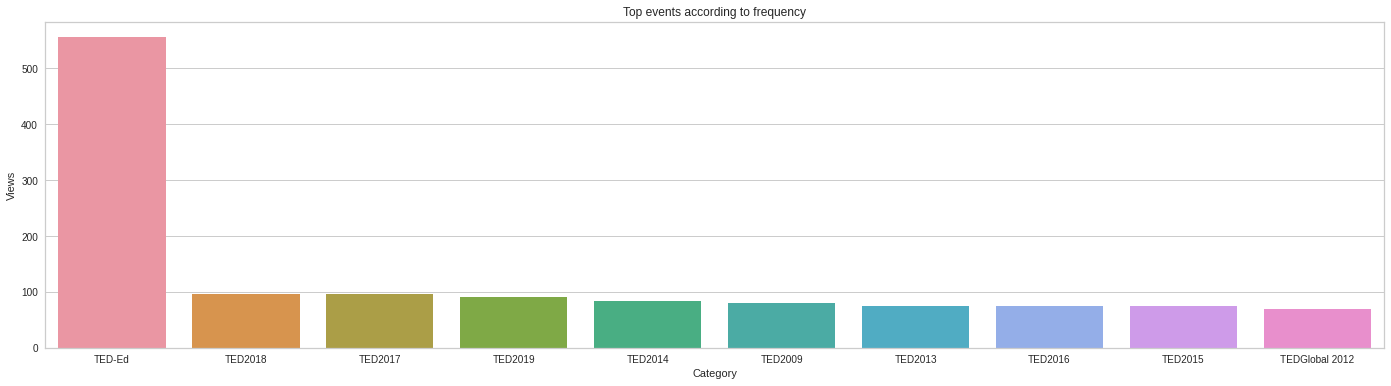

In [ ]:
plt.figure(figsize=(24,6))
plt.title('Top events according to frequency')
sns.barplot(x='event',y='views',data=pd.DataFrame(df.groupby(['event'])['views'].count()).reset_index().sort_values('views',ascending=False).head(10))
plt.xlabel("Category")
plt.ylabel('Views');

In [ ]:
speaker_views_df = pd.DataFrame(df.groupby(['speaker_1'])['title'].count()).reset_index().sort_values('title').reset_index().drop('index',axis=1)
speaker_views_df.groupby(['title'])['speaker_1'].count()

title
1     2850
2      284
3       84
4       31
5        9
6        5
7        2
8        1
9        2
10       2
11       1
12       1
19       1
34       1
Name: speaker_1, dtype: int64

In [ ]:
df = df.merge(right=speaker_views_df,how='inner',on='speaker_1')

In [ ]:
def categorize_event(event_name):
  try:
    event_name = event_name.lower()
    if 'ted-ed' in event_name:
      return 'ted'
    elif len(event_name) == 7 and event_name[3:7].isdigit() and int(event_name[3:7]) in list(range(1984,2020)):
      return 'ted'
    elif 'tedx' in event_name:
      return 'ted-x'
    elif 'tedwomen' in event_name:
      return 'ted-women'
    elif 'tedglobal' in event_name:
      return 'ted-global'
    else:
      return 'other'
  except TypeError:
    pass

In [ ]:
df['event_cat'] = df['event'].apply(categorize_event)
df['native_lang'] = df['native_lang'].apply(lambda x : 'en' if x == 'en' else 'other')
df['video_age'] = 2020 - df['release_year']

In [ ]:
df.drop(['Unnamed: 0', 'talk_id', 'title', 'all_speakers', 'about_speakers', 'available_lang','topics', 'related_talks', 'url', 'description', 'transcript','cleaned_description', 'release_day', 'release_month', 'cleaned_transcription','recorded_date', 'published_date', 'event','release_year','occupation'],axis=1,inplace=True)

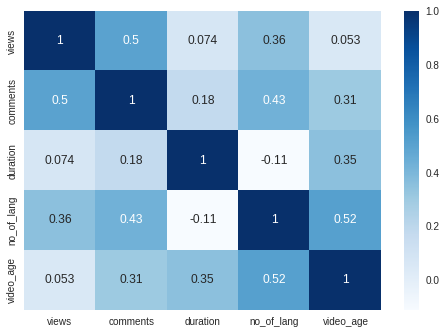

In [ ]:
sns.heatmap(df.corr(),annot=True,cmap='Blues');

In [ ]:
df.to_csv("/content/drive/MyDrive/Capstone 3 Regression/Varun/tmp.csv")

In [ ]:
df['speaker_1'] = df['speaker_1'].map(df.groupby('speaker_1')['views'].mean())

In [ ]:
oe = OrdinalEncoder()
enc = oe.fit(df[['speaker_1','views']])

In [ ]:
df['speaker_1'] = enc.transform(df[['speaker_1','views']])[:,0]

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

comments         261
duration          21
event_cat          0
native_lang        0
no_of_lang       121
speaker_1          0
talk_category      0
video_age          0
views            393
dtype: int64

In [ ]:
num_cols = ['views','duration','comments','no_of_lang','video_age']

In [ ]:
for i in num_cols:
  Q1 = df[i].quantile(0.25)
  Q3 = df[i].quantile(0.75)
  IQR = Q3 - Q1

  df[i]=np.where(df[i]<(Q1 - 1.5 * IQR),(Q1 - 1.5 * IQR),np.where(df[i]>(Q3 + 1.5 * IQR),(Q3 + 1.5 * IQR),df[i]))

In [ ]:
X = df.drop('views',axis=1)
y = df['views'].apply(lambda x : np.log10(x) if x != 0 else 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
numeric_cols = ['comments','duration','no_of_lang','video_age']
ohe_cols = ['native_lang','talk_category','event_cat']

In [ ]:
scaler = StandardScaler()
ohe = OneHotEncoder()
imputer = KNNImputer()

In [ ]:
ct = make_column_transformer(                             
                             (scaler,numeric_cols ),
                             (imputer,['comments']),                             
                             (ohe,ohe_cols),
                             remainder='passthrough',
                             )

In [ ]:
xgb_clf = XGBRegressor(n_jobs=-1)

In [ ]:
pipe = make_pipeline(ct,xgb_clf)

In [ ]:
pipe.fit(X_train,y_train)

ValueError: ignored

In [ ]:
r2_score(10**y_train,10**pipe.predict(X_train))

0.8676031121871404

In [ ]:
r2_score(10**y_test,10**pipe.predict(X_test))

0.8080048402821172

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor
cb_clf = CatBoostRegressor()

     |████████████████████████████████| 76.3 MB 12 kB/s 


In [ ]:
pipe_2 = make_pipeline(ct,cb_clf)

In [ ]:
pipe_2.fit(X_train,y_train)

Learning rate set to 0.049213
0:	learn: 0.4097219	total: 48.5ms	remaining: 48.5s
1:	learn: 0.3983701	total: 50.3ms	remaining: 25.1s
2:	learn: 0.3868898	total: 52.2ms	remaining: 17.3s
3:	learn: 0.3762525	total: 54.1ms	remaining: 13.5s
4:	learn: 0.3661269	total: 56.4ms	remaining: 11.2s
5:	learn: 0.3565710	total: 58.5ms	remaining: 9.69s
6:	learn: 0.3479409	total: 60.4ms	remaining: 8.57s
7:	learn: 0.3390609	total: 62.3ms	remaining: 7.73s
8:	learn: 0.3305292	total: 64.3ms	remaining: 7.08s
9:	learn: 0.3238792	total: 66.2ms	remaining: 6.56s
10:	learn: 0.3168613	total: 68.3ms	remaining: 6.14s
11:	learn: 0.3099955	total: 70.1ms	remaining: 5.78s
12:	learn: 0.3033726	total: 72.1ms	remaining: 5.48s
13:	learn: 0.2972524	total: 74.1ms	remaining: 5.22s
14:	learn: 0.2910165	total: 77.7ms	remaining: 5.1s
15:	learn: 0.2852825	total: 80.2ms	remaining: 4.93s
16:	learn: 0.2801496	total: 83.4ms	remaining: 4.82s
17:	learn: 0.2751114	total: 85.5ms	remaining: 4.66s
18:	learn: 0.2698520	total: 87.5ms	remaining:

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['speaker_1', 'comments',
                                                   'duration', 'no_of_lang',
                                                   'video_age']),
                                                 ('knnimputer', KNNImputer(),
                                                  ['comments']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['native_lang',
                                                   'talk_category',
                                                   'event_cat'])])),
                ('catboostregressor',
                 <catboost.co

In [ ]:
r2_score(10**y_test,10**pipe_2.predict(X_test))

0.8356883617764298

## Ignore

In [ ]:
IQR_Outliers(df,num_cols)

# of features:  5
Features:  ['views', 'duration', 'comments', 'no_of_lang', 'video_age']
Number of samples:  4005

Feature:  views
Upper and Lower limits:  4009671.5 -994492.5
Number of outliers:  393
Outliers Index:  [1, 4, 6, 13, 20, 22, 24, 26, 27, 28, 29, 31, 41, 48, 51, 81, 87, 94, 107, 120, 136, 150, 153, 164, 167, 168, 171, 172, 197, 208, 210, 215, 217, 219, 224, 240, 252, 255, 256, 269, 291, 310, 347, 373, 374, 377, 391, 393, 394, 405, 442, 443, 448, 460, 482, 486, 490, 505, 519, 520, 541, 556, 571, 578, 592, 596, 600, 603, 614, 617, 623, 624, 636, 638, 646, 655, 660, 711, 721, 733, 746, 779, 794, 796, 798, 813, 823, 844, 851, 861, 869, 875, 878, 885, 892, 899, 929, 940, 941, 946, 957, 984, 987, 990, 992, 1015, 1016, 1017, 1070, 1080, 1090, 1091, 1094, 1112, 1113, 1114, 1115, 1120, 1122, 1127, 1144, 1151, 1160, 1161, 1162, 1177, 1183, 1192, 1202, 1225, 1230, 1231, 1248, 1256, 1267, 1296, 1331, 1334, 1335, 1348, 1363, 1366, 1368, 1372, 1385, 1396, 1397, 1398, 1401, 1402, 1408, 

In [ ]:
def IQR_Outliers (X, features):

    print('# of features: ', len(features))
    print('Features: ', features)

    indices = [x for x in X.index]
    #print(indices)
    print('Number of samples: ', len(indices))
    
    out_indexlist = []
        
    for col in features:
       
        #Using nanpercentile instead of percentile because of nan values
        Q1 = np.nanpercentile(X[col], 25.)
        Q3 = np.nanpercentile(X[col], 75.)
        
        cut_off = (Q3 - Q1) * 1.5
        upper, lower = Q3 + cut_off, Q1 - cut_off
        print ('\nFeature: ', col)
        print ('Upper and Lower limits: ', upper, lower)
                
        outliers_index = X[col][(X[col] < lower) | (X[col] > upper)].index.tolist()
        outliers = X[col][(X[col] < lower) | (X[col] > upper)].values
        print('Number of outliers: ', len(outliers))
        print('Outliers Index: ', outliers_index)
        print('Outliers: ', outliers)
        
        out_indexlist.extend(outliers_index)
        
    #using set to remove duplicates
    out_indexlist = list(set(out_indexlist))
    out_indexlist.sort()
    print('\nNumber of rows with outliers: ', len(out_indexlist))
    print('List of rows with outliers: ', out_indexlist)

In [ ]:
def CustomSampler_IQR (X, y):
    
    features = numeric_cols
    df = X.copy()
    df['Outcome'] = y
    
    indices = [x for x in df.index]    
    out_indexlist = []
        
    for col in features:
       
        #Using nanpercentile instead of percentile because of nan values
        Q1 = np.nanpercentile(df[col], 25.)
        Q3 = np.nanpercentile(df[col], 75.)
        
        cut_off = (Q3 - Q1) * 1.5
        upper, lower = Q3 + cut_off, Q1 - cut_off
                
        outliers_index = df[col][(df[col] < lower) | (df[col] > upper)].index.tolist()
        outliers = df[col][(df[col] < lower) | (df[col] > upper)].values        
        out_indexlist.extend(outliers_index)
        
    #using set to remove duplicates
    out_indexlist = list(set(out_indexlist))
    
    clean_data = np.setdiff1d(indices,out_indexlist)

    return X.loc[clean_data], y.loc[clean_data]

In [ ]:
X_train,y_train = CustomSampler_IQR(X_train,y_train)

In [ ]:
X_test,y_test = CustomSampler_IQR(X_test,y_test)

In [ ]:
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

class OutlierExtractor(TransformerMixin):
    def __init__(self, **kwargs):
        """
        Create a transformer to remove outliers. A threshold is set for selection
        criteria, and further arguments are passed to the LocalOutlierFactor class

        Keyword Args:
            neg_conf_val (float): The threshold for excluding samples with a lower
               negative outlier factor.

        Returns:
            object: to be used as a transformer method as part of Pipeline()
        """

        self.threshold = kwargs.pop('neg_conf_val', -10.0)

        self.kwargs = kwargs

    def transform(self, X, y):
        """
        Uses LocalOutlierFactor class to subselect data based on some threshold

        Returns:
            ndarray: subsampled data

        Notes:
            X should be of shape (n_samples, n_features)
        """
        X = np.asarray(X)
        y = np.asarray(y)
        lcf = LocalOutlierFactor(**self.kwargs)
        lcf.fit(X)
        return (X[lcf.negative_outlier_factor_ > self.threshold, :],
                y[lcf.negative_outlier_factor_ > self.threshold])

    def fit(self, *args, **kwargs):
        return self

In [ ]:
r2_score(10**y_train,10**pipe_2.predict(X_train))

0.926971856005421

In [ ]:
encoder=TargetEncoder(cols=['speaker_1'])
encoded_train = encoder.fit_transform(X_train['speaker_1'],y_train).values
X_train['speaker_1'] = encoded_train 
encoded_test = encoder.transform(X_test['speaker_1'],y_test).values
X_test['speaker_1'] = encoded_test